<a href="https://colab.research.google.com/github/SegaObin/PET-projects/blob/main/all_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка необходимых библиотек и инициализация функций

In [1]:
import pandas as pd # пандас для работы с датафреймами
import matplotlib.pyplot as plt # Библиотека для создания визуализаций данных.
import warnings # Используется для управления предупреждениями (warnings) в Python.
import matplotlib.pyplot as plt #Библиотека для создания визуализаций данных.
import matplotlib.dates as mdates #форматирование,отображение и манипуляция с датами на графиках
import numpy as np #Библиотека для численных вычислений.предоставляет поддержку многомерных массивов и матриц
from datetime import timedelta# Модуль для работы с датами и временем.
from statsmodels.graphics.tsaplots import plot_acf   # Функция для построения графика автокорреляционной функции (ACF).
from statsmodels.graphics.tsaplots import plot_pacf   # Функция для построения графика частичной автокорреляционной функции (PACF).
from statsmodels.tsa.seasonal import seasonal_decompose #функция для декомпозиции временных рядов, сезонную составляющую и остаток
from pylab import rcParams #параметры для графиков
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA #Библиотека для статистического анализа и построения временных рядов.
from statsmodels.tsa.stattools import adfuller #для теста Дики-Фуллера

from google.colab import drive
warnings.filterwarnings('ignore')

Пути необходимо поменять на свои, чтобы код работал

In [2]:
drive.mount('/content/drive')
war = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/WAR_Month.csv')
s_ok = pd.read_csv('/content/drive/MyDrive/S_OK_Month.csv')
err = pd.read_csv('/content/drive/MyDrive/ERR_Month.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def show_data(df, title='Грфик временного ряда', y_label='Имя колонки'):
    date_form = mdates.DateFormatter("%d-%m")

    plt.figure(figsize=(12, 8))

    for column in df.columns:
        plt.plot(df[column], label=column)

    interval = len(df) // 10

    plt.gca().set_xlabel('Дни')
    plt.gca().xaxis.set_major_formatter(date_form)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    plt.legend()
    plt.xlabel('Дата')
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [4]:
def train_test_split(df, start_date='2024-09-24', end_date='2024-11-27', prediction_period=4):
  prediction_period = timedelta(days=prediction_period)

  # Преобразуем в datetime
  start_date_data = pd.to_datetime(start_date)
  end_date_data = pd.to_datetime(end_date)

  # Фильтруем данные по диапазону дат
  df_period = df[(df.index >= start_date_data) & (df.index <= end_date_data)]

  # Определяем точку разделения
  split_date = end_date_data - prediction_period

  # Разделяем на train и test
  train = df_period[df_period.index <= split_date]
  test = df_period[df_period.index > split_date]

  return train, test

In [5]:
def dickey_fuller_test(df):
    """
    Проводит тест Дики-Фуллера на стационарность для всех колонок DataFrame.
    """
    for column in df.columns:
        result = adfuller(df[column])
        adf_stat = result[0]
        p_value = result[1]
        crit_values = result[4]

        print(f"\n{'='*40}")
        print(f"Результаты теста Дики-Фуллера для '{column}':")
        print(f"{'='*40}")
        print(f"ADF статистика: {adf_stat:.4f}")
        print(f"P-значение:      {p_value:.4f}")

        is_stationary = p_value < 0.05
        status = "СТАЦИОНАРЕН" if is_stationary else "НЕСТАЦИОНАРЕН"
        print(f"Результат (α=0.05): {status}")

        print(f"\nКритические значения:")
        for level, value in crit_values.items():
            comparison = "<" if adf_stat < value else ">="
            print(f"  {level}%: {value:.3f} (ADF {comparison} {value:.3f})")

    print(f"\n{'='*40}")

In [6]:
def seasonal(df):
  plt.rcParams['figure.figsize'] = (11, 9)

  for column in df.columns:
      series = df[column]
      decompose = seasonal_decompose(series, period=6)
      fig = decompose.plot()
      plt.show()

In [7]:
def show_auto_correlation_grafs(df, title='Графики автокореляции'):
    for column in df.columns:
        try:
            plot_acf(df[column], title=title+" ACF")
            plt.show()

            n_lags = int(len(df[column]) * 0.5)
            plot_pacf(df[column], lags=n_lags, title=title+" PACF")
            plt.show()
        except Exception as e:
            print(f"Не удалось построить ACF/PACF для {column}: {e}")

In [8]:
def difference_series(ts, order=1):
    """
    Дифференцирует временной ряд order раз.
    Возвращает дифференцированный ряд и последние исходные значения,
    нужные для обратного преобразования.
    """
    original_last_values = []

    diff_ts = ts.copy()
    for i in range(order):
        original_last_values.append(diff_ts.iloc[-1])
        diff_ts = diff_ts.diff().dropna()

    return diff_ts, original_last_values


def inverse_difference(last_values, diff_forecast):
    """
    Восстанавливает исходный временной ряд после k-кратного дифференцирования.

    last_values — список последних исходных значений
                  (перед каждым дифференцированием).
    diff_forecast — предсказанный ряд (после дифференцирования).
    """
    restored = diff_forecast.copy()

    # По шагам — в обратном порядке
    for last_val in reversed(last_values):
        temp = []
        prev = last_val
        for d in restored:
            value = prev + d
            temp.append(value)
            prev = value
        restored = temp

    return restored


In [9]:
def remove_seasonality(ts, period, model="additive"):
    """
    Удаляет сезонность из ряда.
    Возвращает:
        adjusted      — ряд без сезонности
        seasonal_part — сама сезонность (чтобы восстановить позже)
    """
    decomp = seasonal_decompose(ts, model=model, period=period)
    seasonal = decomp.seasonal

    adjusted = ts - seasonal
    return adjusted, seasonal

def add_back_seasonality(forecast, seasonal_pattern):
    """
    Возвращает сезонность в прогноз.
    forecast — массив / Series прогноза
    seasonal_pattern — сезонные значения для прогноза
                       длина должна совпадать с forecast
    """
    seasonal_pattern = seasonal_pattern[:len(forecast)]
    return forecast + seasonal_pattern

In [10]:
def plot_with_rolling_window(df, window=5):
  date_form = mdates.DateFormatter("%d-%m")

  for column in df.columns:
      plt.figure(figsize=(15, 8))
      plt.gca().xaxis.set_major_formatter(date_form)
      plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=len(df)//10))

      plt.plot(df[column], label=column, color='steelblue')
      plt.plot(df[column].rolling(window=window).mean(),
              label='Скользящее среднее', color='red')

      plt.legend(title='', loc='upper left', fontsize=14)
      plt.xlabel('Дни', fontsize=14)
      plt.title(column, fontsize=16)
      plt.show()

In [11]:
def find_best_arima_params(series, max_p=2, max_d=1, max_q=2):
    best_aic = np.inf
    best_order = None
    best_model = None

    for d in range(max_d + 1):
        for p in range(max_p + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    fitted_model = model.fit()

                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_model = fitted_model

                    print(f"ARIMA({p},{d},{q}) - AIC: {fitted_model.aic:.2f}")

                except Exception:
                    continue

    print(f"\nЛучшая модель: ARIMA{best_order} с AIC: {best_aic:.2f}")
    return best_order, best_model

In [12]:
def forecast_arima(train_data, test_data, auto_params=True, custom_order=None,
                   difference_order=0, use_seasonality_removal=False,
                   forecast_limit=None, show_iterative_metrics=True):
    """
    Прогнозирование ARIMA с расширенными возможностями визуализации

    Parameters:
    -----------
    forecast_limit : int, optional
        Ограничить количество показываемых предсказаний (обрезать график справа)
    show_iterative_metrics : bool, default=True
        Показывать метрики для каждого шага (не кумулятивные)
    """
    print(f"Размер обучающей выборки: {len(train_data)}")
    print(f"Размер тестовых данных: {len(test_data)}")
    print(f"Прогноз на {len(test_data)} шагов вперед")

    if isinstance(train_data, pd.DataFrame):
        train_data = train_data.iloc[:, 0] if len(train_data.columns) == 1 else train_data.squeeze()
    if isinstance(test_data, pd.DataFrame):
        test_data = test_data.iloc[:, 0] if len(test_data.columns) == 1 else test_data.squeeze()

    # Сохраняем оригинальные данные для восстановления
    original_train = train_data.copy()
    original_test = test_data.copy()
    n_forecast = len(test_data)  # Запоминаем требуемое количество шагов прогноза

    # Обработка сезонности только на train
    seasonal_pattern = None
    period = 7

    if use_seasonality_removal:
        train_data, seasonal_pattern = remove_seasonality(train_data, period)
        print(f"Удалена сезонность с периодом {period} (только на train)")

    # Дифференцирование только на train
    last_values = None

    if difference_order > 0:
        train_data, last_values = difference_series(train_data, order=difference_order)
        print(f"Применено дифференцирование порядка {difference_order} (только на train)")

    if auto_params:
        best_order, best_model = find_best_arima_params(train_data)
        model_name = f"ARIMA{best_order}"
    else:
        if custom_order is None:
            raise ValueError("При auto_params=False необходимо указать custom_order")
        best_order = custom_order
        best_model = ARIMA(train_data, order=best_order).fit()
        model_name = f"ARIMA{best_order}"

    # Выводим summary модели SARIMAX
    print(f"\n{'='*70}")
    print(f"SUMMARY МОДЕЛИ {model_name}")
    print(f"{'='*70}")
    print(best_model.summary())

    # Прогнозируем на дифференцированных/десезонированных данных
    forecast = best_model.forecast(steps=n_forecast)

    # Преобразуем в numpy array для удобства
    if isinstance(forecast, pd.Series):
        forecast_values = forecast.values.copy()
    else:
        forecast_values = np.array(forecast).copy()

    # Обратное преобразование дифференцирования
    if difference_order > 0 and last_values is not None:
        forecast_series = pd.Series(forecast_values)
        forecast_series = inverse_difference(last_values, forecast_series)
        forecast_values = forecast_series.values if isinstance(forecast_series, pd.Series) else np.array(forecast_series)
        train_data = original_train.iloc[difference_order:]

    # Добавление сезонности обратно
    if use_seasonality_removal and seasonal_pattern is not None:
        # ИСПРАВЛЕНИЕ: Создаем расширенный паттерн сезонности для ВСЕГО периода прогноза
        pattern_length = len(seasonal_pattern)

        # Расширяем паттерн циклически до нужной длины
        extended_seasonal_values = []
        for i in range(n_forecast):
            idx = i % pattern_length
            extended_seasonal_values.append(seasonal_pattern.iloc[idx])

        extended_seasonal = np.array(extended_seasonal_values)

        # Убеждаемся что длины совпадают
        if len(forecast_values) != len(extended_seasonal):
            print(f"Предупреждение: корректировка длины прогноза с {len(forecast_values)} до {len(extended_seasonal)}")
            if len(forecast_values) < len(extended_seasonal):
                # Дополняем forecast последним значением
                forecast_values = np.pad(forecast_values,
                                         (0, len(extended_seasonal) - len(forecast_values)),
                                         mode='edge')
            else:
                forecast_values = forecast_values[:len(extended_seasonal)]

        # Добавляем сезонность обратно
        forecast_values = forecast_values + extended_seasonal
        train_data = original_train

    # Создаем финальный forecast как Series с правильным индексом
    # Убеждаемся что длина совпадает с original_test
    if len(forecast_values) != n_forecast:
        print(f"Корректировка: длина forecast ({len(forecast_values)}) -> {n_forecast}")
        if len(forecast_values) > n_forecast:
            forecast_values = forecast_values[:n_forecast]
        else:
            # Дополняем последним значением
            forecast_values = np.pad(forecast_values,
                                     (0, n_forecast - len(forecast_values)),
                                     mode='edge')

    forecast = pd.Series(forecast_values, index=original_test.index)

    # Ограничиваем данные для отображения если указано
    if forecast_limit and forecast_limit < len(test_data):
        test_display = original_test.iloc[:forecast_limit]
        forecast_display = forecast.iloc[:forecast_limit]
        print(f"\nГрафик ограничен первыми {forecast_limit} предсказаниями")
    else:
        test_display = original_test
        forecast_display = forecast
        forecast_limit = len(test_data)

    # Выводим метрики качества
    print(f"\n{'='*70}")
    print(f"МЕТРИКИ КАЧЕСТВА ПРОГНОЗА ({model_name})")
    print(f"{'='*70}")

    # Кумулятивные метрики (одним числом)
    cumulative_mse = mean_squared_error(original_test, forecast)
    cumulative_mae = mean_absolute_error(original_test, forecast)
    cumulative_mape = mean_absolute_percentage_error(original_test, forecast) if all(x != 0 for x in original_test) else np.nan

    print(f"\nКумулятивные метрики на всех {len(test_data)} шагах:")
    print(f"  MSE:  {cumulative_mse:.2f}")
    print(f"  MAE:  {cumulative_mae:.2f}")
    print(f"  MAPE: {cumulative_mape*100 if not np.isnan(cumulative_mape) else 'N/A':.2f}%")
    print(f"  RMSE: {np.sqrt(cumulative_mse):.2f}")

    # Метрики для отображаемой части
    if forecast_limit < len(test_data):
        display_mse = mean_squared_error(test_display, forecast_display)
        display_mae = mean_absolute_error(test_display, forecast_display)
        display_mape = mean_absolute_percentage_error(test_display, forecast_display) if all(x != 0 for x in test_display) else np.nan

        print(f"\nКумулятивные метрики на отображаемых {forecast_limit} шагах:")
        print(f"  MSE:  {display_mse:.2f}")
        print(f"  MAE:  {display_mae:.2f}")
        print(f"  MAPE: {display_mape*100 if not np.isnan(display_mape) else 'N/A':.2f}%")
        print(f"  RMSE: {np.sqrt(display_mse):.2f}")

    # Пошаговые метрики (не кумулятивные)
    if show_iterative_metrics and forecast_limit <= 15:
        print(f"\nПошаговые метрики (не кумулятивные) для {forecast_limit} предсказаний:")
        print("-" * 70)
        print("Шаг | Прогноз  | Факт    | Ошибка  | MSE шага | MAE шага | MAPE шага%")
        print("-" * 70)

        for i in range(forecast_limit):
            step_actual = test_display.iloc[i]
            step_forecast = forecast_display.iloc[i]
            error = step_actual - step_forecast

            step_mse = error ** 2
            step_mae = abs(error)
            step_mape = abs(error / step_actual) if step_actual != 0 else np.nan

            print(f"{i+1:4d} | {step_forecast:7.2f} | {step_actual:6.2f} | {error:7.2f} | {step_mse:9.2f} | {step_mae:9.2f} | {step_mape*100 if not np.isnan(step_mape) else 'N/A':10.2f}%")

        print("-" * 70)
        avg_step_mse = np.mean([(test_display.iloc[i] - forecast_display.iloc[i])**2 for i in range(forecast_limit)])
        avg_step_mae = np.mean([abs(test_display.iloc[i] - forecast_display.iloc[i]) for i in range(forecast_limit)])
        print(f"Среднее по шагам: MSE: {avg_step_mse:.2f}, MAE: {avg_step_mae:.2f}")

    # График с настройками отображения
    plt.figure(figsize=(15, 10))

    # Создаем единый временной ряд: train + ограниченный test
    if forecast_limit and forecast_limit < len(test_data):
        test_for_plot = original_test.iloc[:forecast_limit]
        full_series = pd.concat([original_train, test_for_plot])
    else:
        full_series = pd.concat([original_train, original_test])

    all_dates = full_series.index
    all_values = full_series.values

    # Определяем данные для отображения
    if forecast_limit and forecast_limit < len(test_data):
        test_show = test_for_plot
        forecast_show = forecast_display
    else:
        test_show = original_test
        forecast_show = forecast_display

    # Первый график: train и test одной линией
    plt.subplot(2, 1, 1)

    # Одна непрерывная линия для всех данных
    plt.plot(all_dates, all_values, color='blue', linewidth=2)

    # Подкрашиваем test часть зеленым цветом поверх синей линии
    train_end_idx = len(original_train)
    test_start_idx = train_end_idx
    test_end_idx = len(full_series)

    # Рисуем поверх синей линии зеленую линию для test части
    plt.plot(all_dates[test_start_idx:test_end_idx], all_values[test_start_idx:test_end_idx],
             color='green', linewidth=3, alpha=0.7)

    # Прогноз красной линией
    forecast_start_idx = test_start_idx
    forecast_end_idx = test_start_idx + len(forecast_show)
    forecast_dates_display = all_dates[forecast_start_idx:forecast_end_idx]
    plt.plot(forecast_dates_display, forecast_show, label='Прогноз', color='red',
             linestyle='--', linewidth=2, marker='o', markersize=4)

    # Добавляем легенду с элементами
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Обучающие данные'),
        Line2D([0], [0], color='green', lw=2, label='Тестовые данные'),
        Line2D([0], [0], color='red', linestyle='--', lw=2, label='Прогноз')
    ]
    plt.legend(handles=legend_elements, fontsize=11)

    # Вертикальная линия разделения train/test
    separation_date = all_dates[train_end_idx - 1]
    plt.axvline(x=separation_date, color='gray', linestyle=':', alpha=0.7, linewidth=1)

    plt.title(f'Прогноз модели {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Дата', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.grid(True, alpha=0.3)

    # Второй график: только предсказания vs фактические значения
    plt.subplot(2, 1, 2)

    # Индексы для предсказаний
    steps = range(1, len(test_show) + 1)

    # График фактических и предсказанных значений
    plt.plot(steps, test_show.values, label='Фактические значения', color='green',
             linewidth=2, marker='s', markersize=6)
    plt.plot(steps, forecast_show.values, label='Предсказанные значения', color='red',
             linewidth=2, linestyle='--', marker='o', markersize=6)

    # Добавляем линии ошибок
    for i, (actual, pred) in enumerate(zip(test_show.values, forecast_show.values)):
        plt.plot([i+1, i+1], [actual, pred], color='orange', alpha=0.5, linewidth=1)

    plt.title(f'Сравнение предсказаний и фактических значений', fontsize=12)
    plt.xlabel('Шаг прогноза', fontsize=12)
    plt.ylabel('Значение', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Добавляем подписи значений
    for i, (actual, pred) in enumerate(zip(test_show.values, forecast_show.values)):
        plt.text(i+1, actual, f'{actual:.1f}', ha='center', va='bottom', fontsize=9)
        plt.text(i+1, pred, f'{pred:.1f}', ha='center', va='top', fontsize=9)

    plt.tight_layout()
    plt.show()

    return forecast, best_model, best_order

# Работа с WAR и SUC так как они идентичны

In [13]:
war.head()

,Datetime,WAR
0,24-09-24,6
1,24-09-25,311
2,24-09-26,69
3,24-09-27,11
4,24-09-28,7


In [14]:
war['Datetime'] = pd.to_datetime(war['Datetime'], format='%y-%m-%d')
war.set_index('Datetime', inplace=True)
war = war[:'2024-11-25']
war.tail()

,WAR
Datetime,
2024-11-21,470
2024-11-22,385
2024-11-23,372
2024-11-24,408
2024-11-25,374


В `prediction_period` настравиаем количество дней на которых мы будем делать прогноз, по умолчанию 4 указываю чтобы было пнятно как работать с функцией

In [15]:
train_war, test_war = train_test_split(war, start_date='2024-09-24', end_date='2024-11-25', prediction_period=4)
train_war.tail(1), test_war.head(1)

(            WAR
 Datetime       
 2024-11-21  470,
             WAR
 Datetime       
 2024-11-22  385)

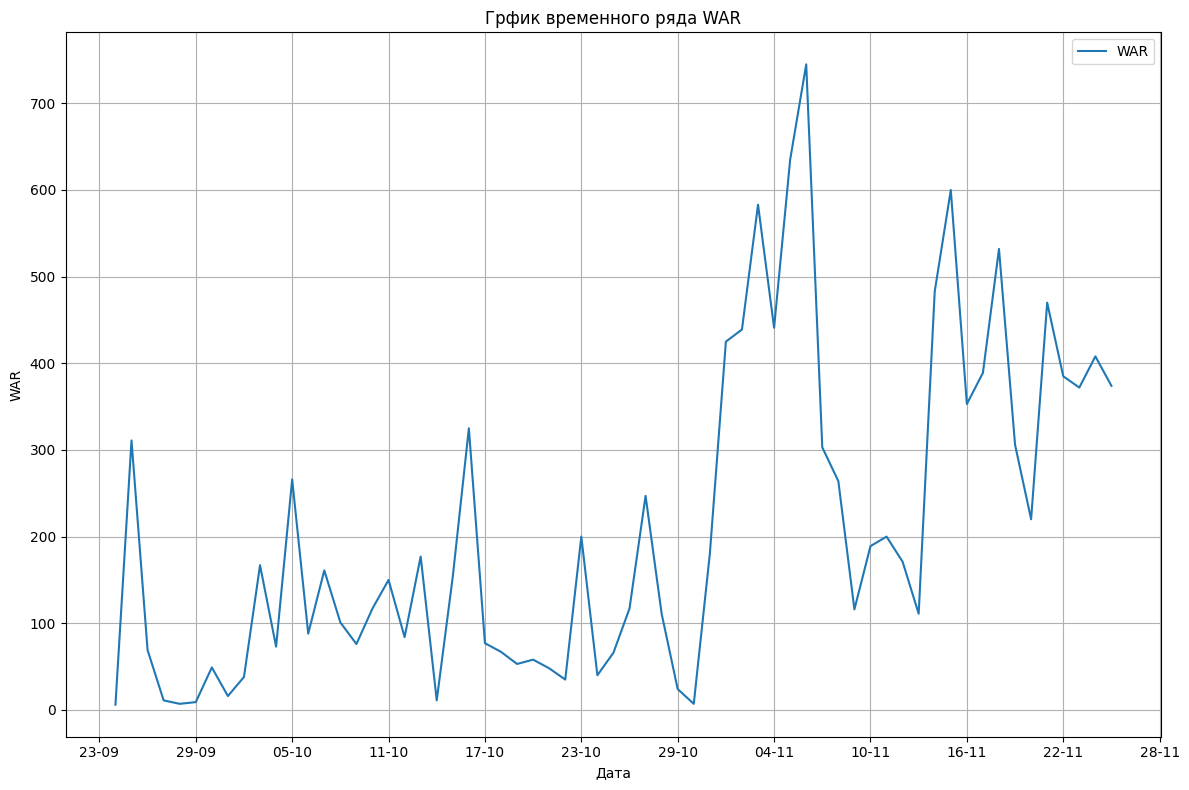

In [16]:
show_data(war, title='Грфик временного ряда WAR', y_label=str(*war.columns))

Временное разложение ряда на основные составляющие

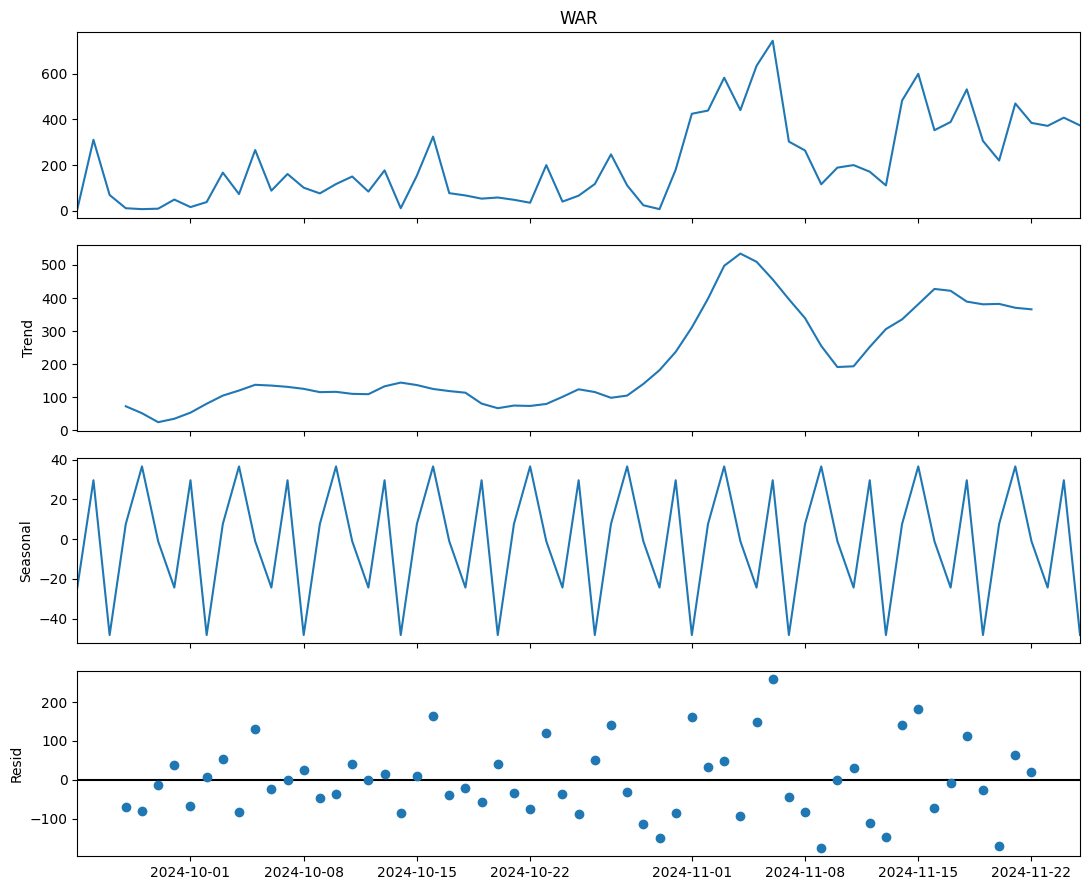

In [17]:
seasonal(war)

Большие остатки. Сезонность есть; сезонность недельная. Выраженного тренда нет, скорее всего из-за малого количества доступных данных.

Проверка на стационарность при помощи теста Дики Фуллера.

In [18]:
dickey_fuller_test(war)


Результаты теста Дики-Фуллера для 'WAR':
ADF статистика: -3.3688
P-значение:      0.0121
Результат (α=0.05): СТАЦИОНАРЕН

Критические значения:
  1%%: -3.541 (ADF >= -3.541)
  5%%: -2.909 (ADF < -2.909)
  10%%: -2.592 (ADF < -2.592)



Графики ACF и PCF для определения параметров модели.

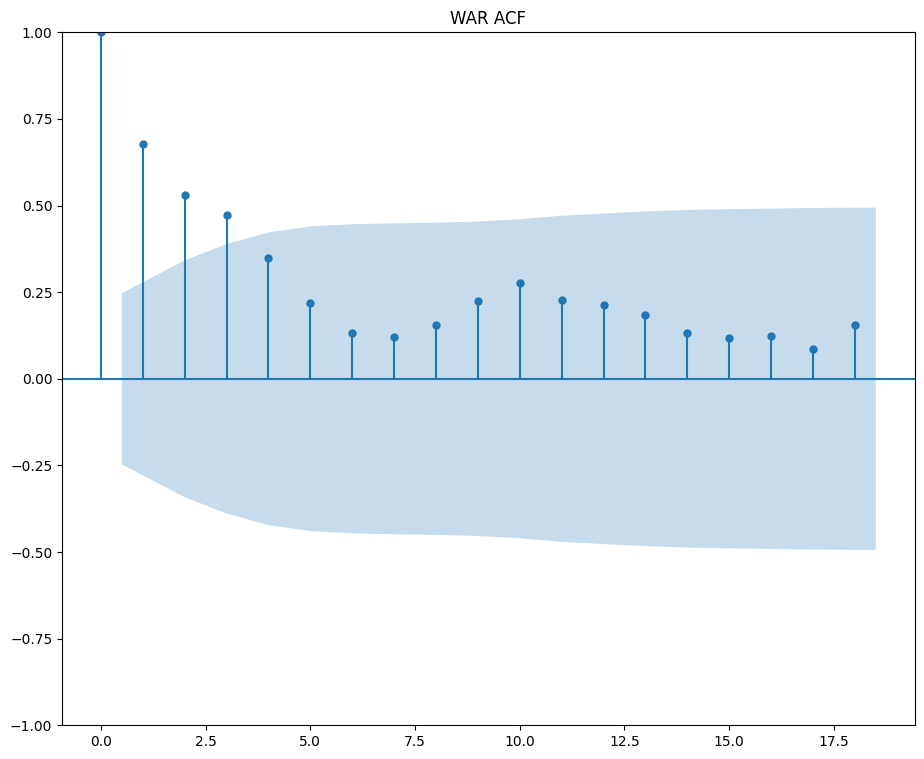

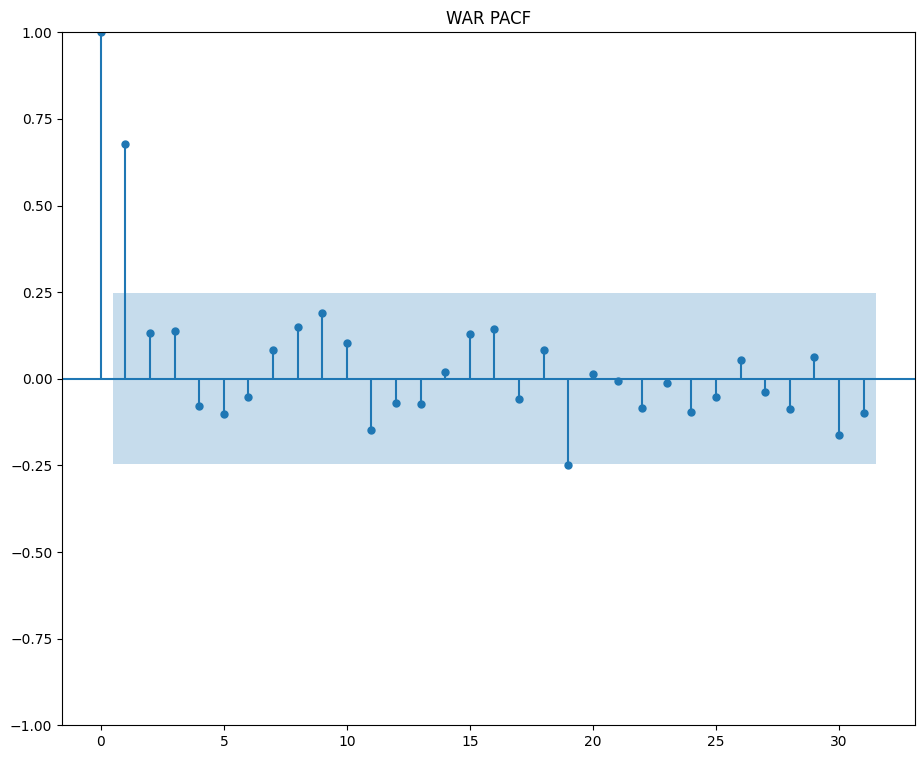

In [19]:
show_auto_correlation_grafs(war, title='WAR')

Продиференцируем графики для повышения стационарносить и устранания проблемы, того что на ACF значения только положительные

Дифференцируем только train

In [20]:
train_war_diff, original_last_values_war = difference_series(train_war)

In [21]:
dickey_fuller_test(train_war_diff)


Результаты теста Дики-Фуллера для 'WAR':
ADF статистика: -7.3059
P-значение:      0.0000
Результат (α=0.05): СТАЦИОНАРЕН

Критические значения:
  1%%: -3.553 (ADF < -3.553)
  5%%: -2.915 (ADF < -2.915)
  10%%: -2.595 (ADF < -2.595)



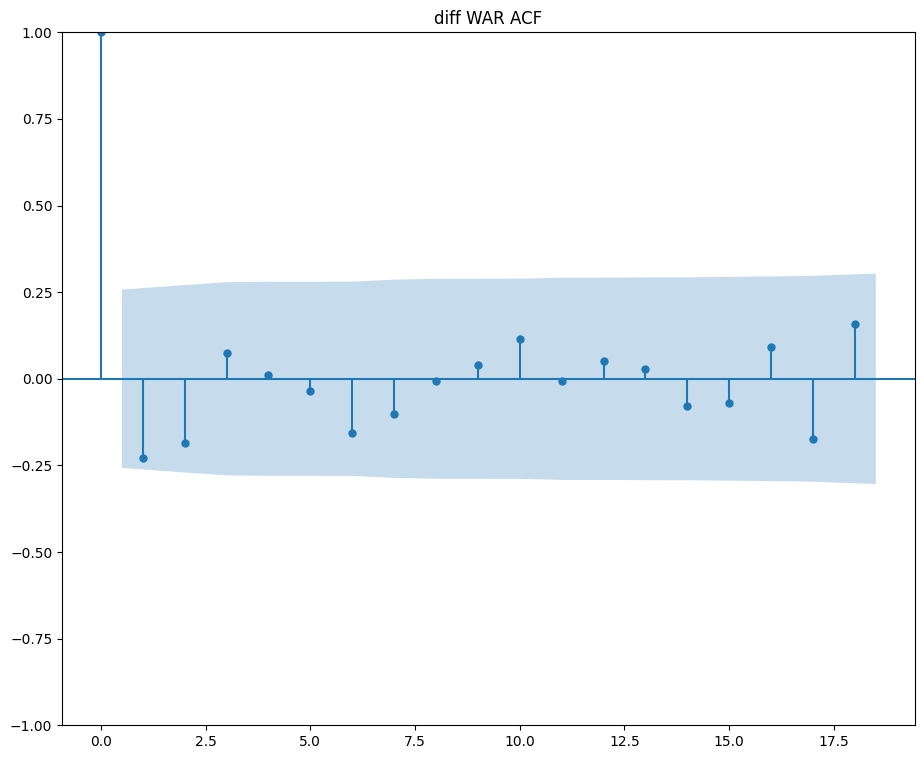

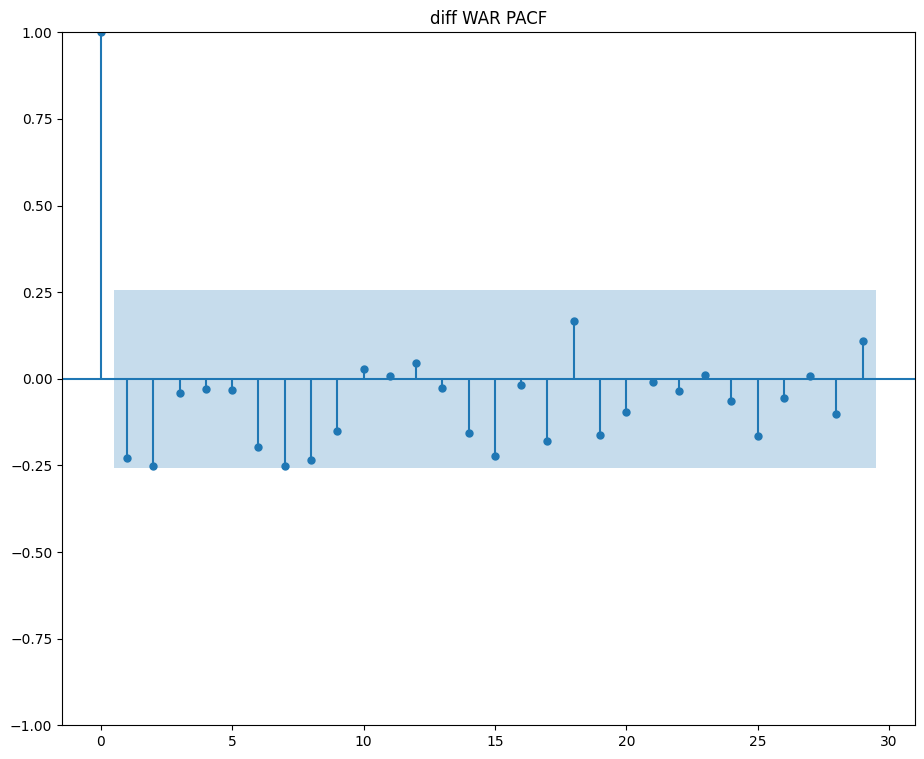

In [22]:
show_auto_correlation_grafs(train_war_diff, title='diff WAR')

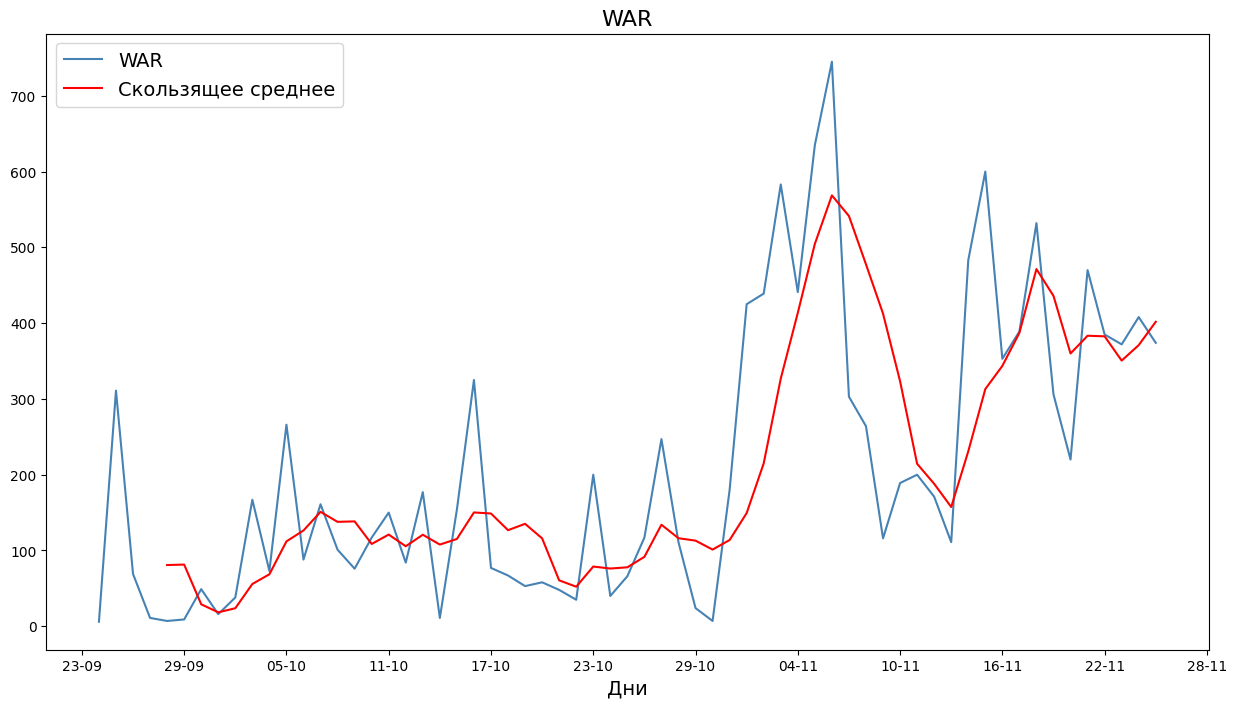

In [23]:
plot_with_rolling_window(war, window=5) # при помощи параметра window можно настроить ширину скользящего окна

Подбор модели, предсказание и визуализация предсказания.

Размер обучающей выборки: 59
Размер тестовых данных: 4
Прогноз на 4 шагов вперед
ARIMA(0,0,0) - AIC: 786.12
ARIMA(0,0,1) - AIC: 764.51
ARIMA(0,0,2) - AIC: 762.73
ARIMA(1,0,0) - AIC: 754.10
ARIMA(1,0,1) - AIC: 754.99
ARIMA(1,0,2) - AIC: 756.65
ARIMA(2,0,0) - AIC: 755.39
ARIMA(2,0,1) - AIC: 756.89
ARIMA(2,0,2) - AIC: 758.10
ARIMA(0,1,0) - AIC: 746.79
ARIMA(0,1,1) - AIC: 742.98
ARIMA(0,1,2) - AIC: 742.31
ARIMA(1,1,0) - AIC: 745.32
ARIMA(1,1,1) - AIC: 741.17
ARIMA(1,1,2) - AIC: 743.13
ARIMA(2,1,0) - AIC: 743.47
ARIMA(2,1,1) - AIC: 745.46
ARIMA(2,1,2) - AIC: 744.91

Лучшая модель: ARIMA(1, 1, 1) с AIC: 741.17

SUMMARY МОДЕЛИ ARIMA(1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                    WAR   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -367.585
Date:                Fri, 19 Dec 2025   AIC                            741.169
Time:                        21:09:14   B

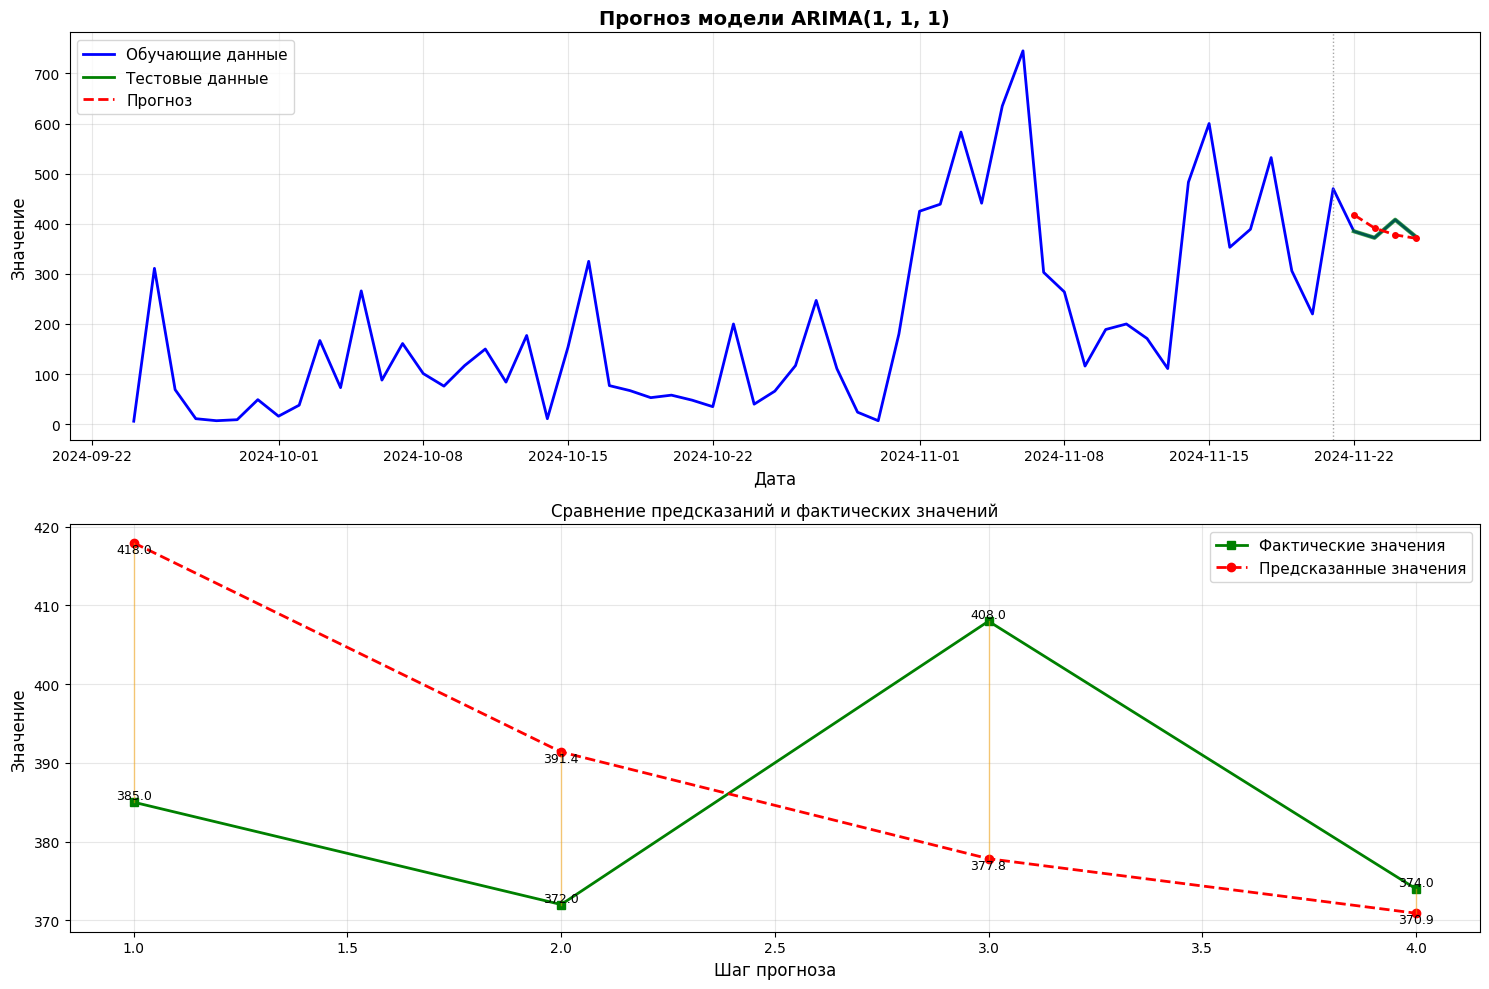

In [24]:
forecast, model, order = forecast_arima(
    train_war, test_war,
    auto_params=True, # ставим автоматический поиск лучшей модели по сетке параметров
    difference_order=0, # настройка ширины окна дифференцированя
    use_seasonality_removal=False, # настройка сезонности (True - удаляем, False - оставляем)
    forecast_limit=5, # Настраиваем обрезку количества предсказаний (обрезка датаврема с конца)
    show_iterative_metrics=True # Настрока отображения метрик по каждой итерации
)

# Работа с S_OK

In [25]:

s_ok.head()

,Datetime,S_OK
0,24-09-24,99
1,24-09-25,252
2,24-09-26,158
3,24-09-27,48
4,24-09-28,30


In [26]:
s_ok['Datetime'] = pd.to_datetime(s_ok['Datetime'], format='%y-%m-%d')
s_ok.set_index('Datetime', inplace=True)
s_ok = s_ok[:'2024-11-26']
s_ok.tail()

,S_OK
Datetime,
2024-11-22,315
2024-11-23,304
2024-11-24,330
2024-11-25,323
2024-11-26,335


In [27]:
train_s_ok, test_s_ok = train_test_split(s_ok, start_date='2024-09-24', end_date='2024-11-26')
train_s_ok.tail(1), test_s_ok.head(1)

(            S_OK
 Datetime        
 2024-11-22   315,
             S_OK
 Datetime        
 2024-11-23   304)

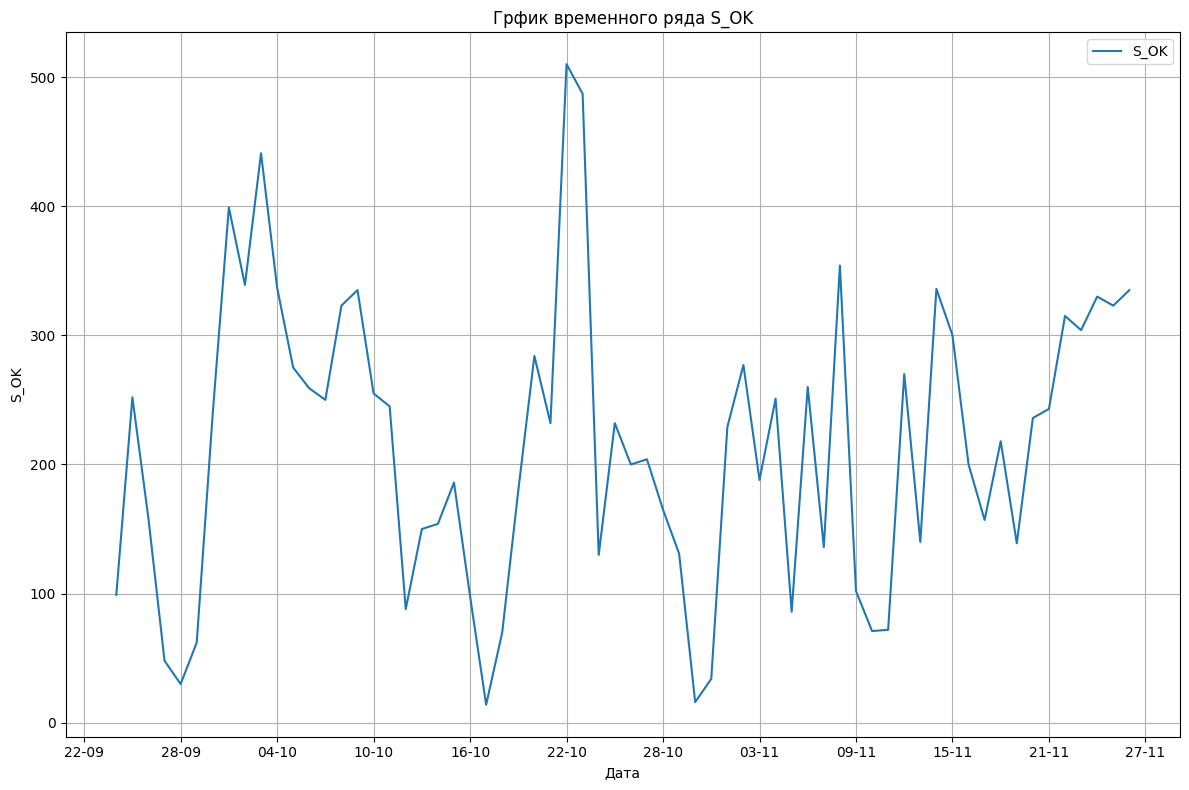

In [28]:
show_data(s_ok, title='Грфик временного ряда S_OK', y_label=str(*s_ok.columns))

Разложение временного ряда на основные составляющие

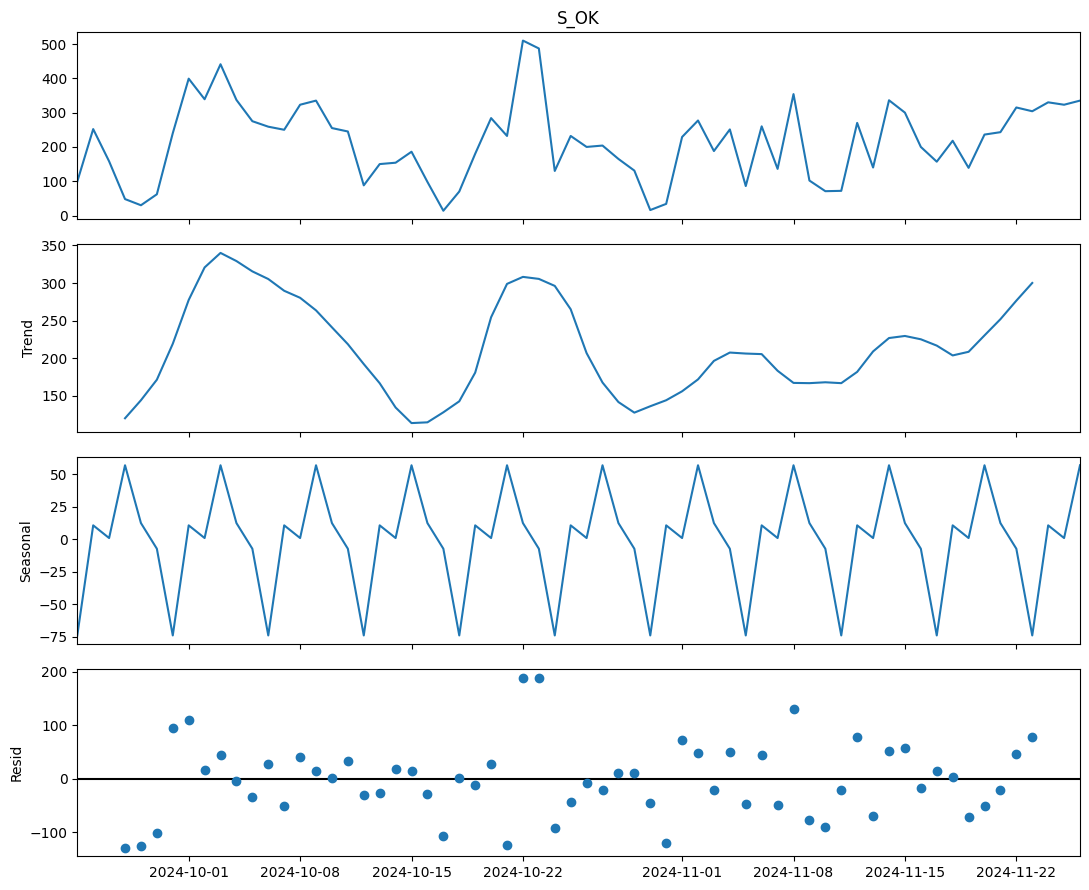

In [29]:
seasonal(s_ok)

Сезоность недельная. Есть достаточно большие остатки. Под конец графика тренда замечается небольшой тренд на повышение, но вряд-ли это может говорить, что такой тренд может исказить работу модели.

Тест на стационарность про помощи Дики Фуллера

In [30]:
dickey_fuller_test(s_ok)


Результаты теста Дики-Фуллера для 'S_OK':
ADF статистика: -4.5758
P-значение:      0.0001
Результат (α=0.05): СТАЦИОНАРЕН

Критические значения:
  1%%: -3.539 (ADF < -3.539)
  5%%: -2.909 (ADF < -2.909)
  10%%: -2.592 (ADF < -2.592)



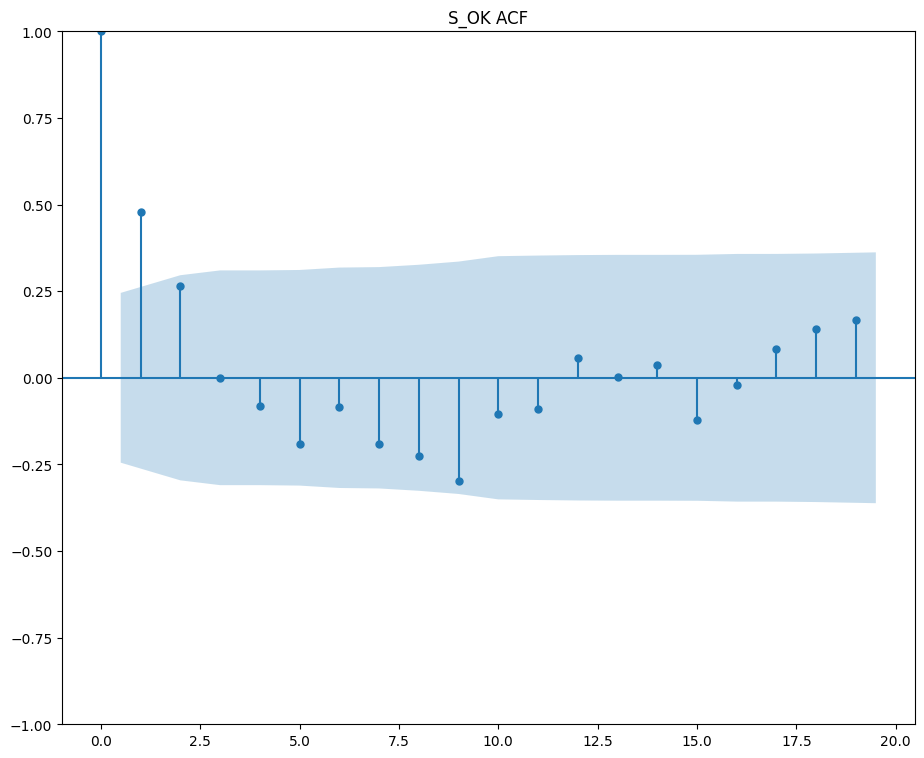

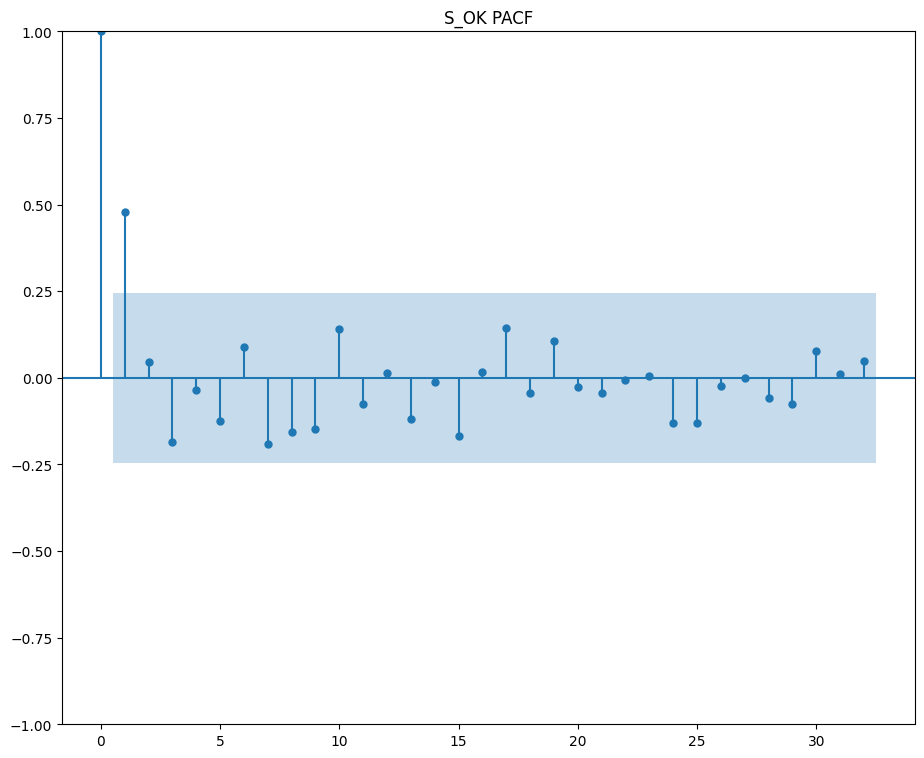

In [31]:
show_auto_correlation_grafs(s_ok, title='S_OK')

В отличае от WAR и SUC дифференцирование не требуется.

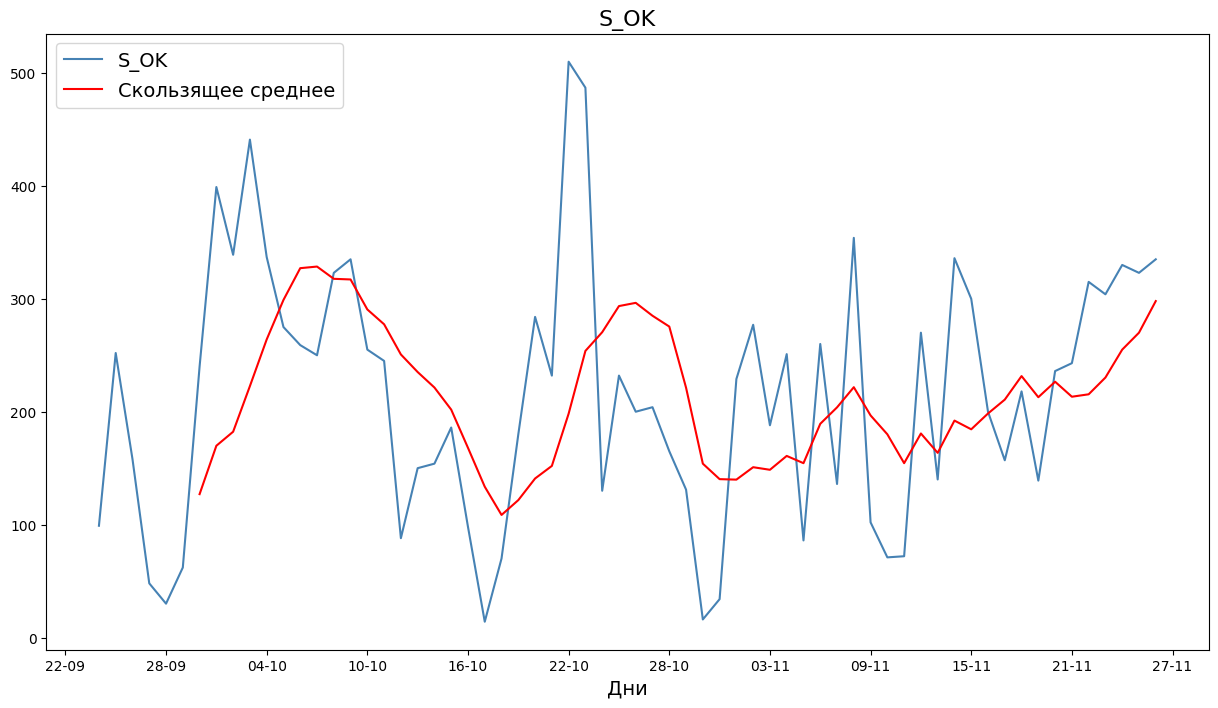

In [32]:
plot_with_rolling_window(s_ok, window=7)

Размер обучающей выборки: 60
Размер тестовых данных: 4
Прогноз на 4 шагов вперед
Удалена сезонность с периодом 7 (только на train)
Применено дифференцирование порядка 2 (только на train)
ARIMA(0,0,0) - AIC: 769.03
ARIMA(0,0,1) - AIC: 722.05
ARIMA(0,0,2) - AIC: 719.67
ARIMA(1,0,0) - AIC: 743.22
ARIMA(1,0,1) - AIC: 720.10
ARIMA(1,0,2) - AIC: 719.09
ARIMA(2,0,0) - AIC: 741.24
ARIMA(2,0,1) - AIC: 722.09
ARIMA(2,0,2) - AIC: 720.46
ARIMA(0,1,0) - AIC: 821.14
ARIMA(0,1,1) - AIC: 760.82
ARIMA(0,1,2) - AIC: 718.91
ARIMA(1,1,0) - AIC: 773.10
ARIMA(1,1,1) - AIC: 736.41
ARIMA(1,1,2) - AIC: 717.81
ARIMA(2,1,0) - AIC: 763.77
ARIMA(2,1,1) - AIC: 734.98
ARIMA(2,1,2) - AIC: 719.80

Лучшая модель: ARIMA(1, 1, 2) с AIC: 717.81

SUMMARY МОДЕЛИ ARIMA(1, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -354.907
Date:         

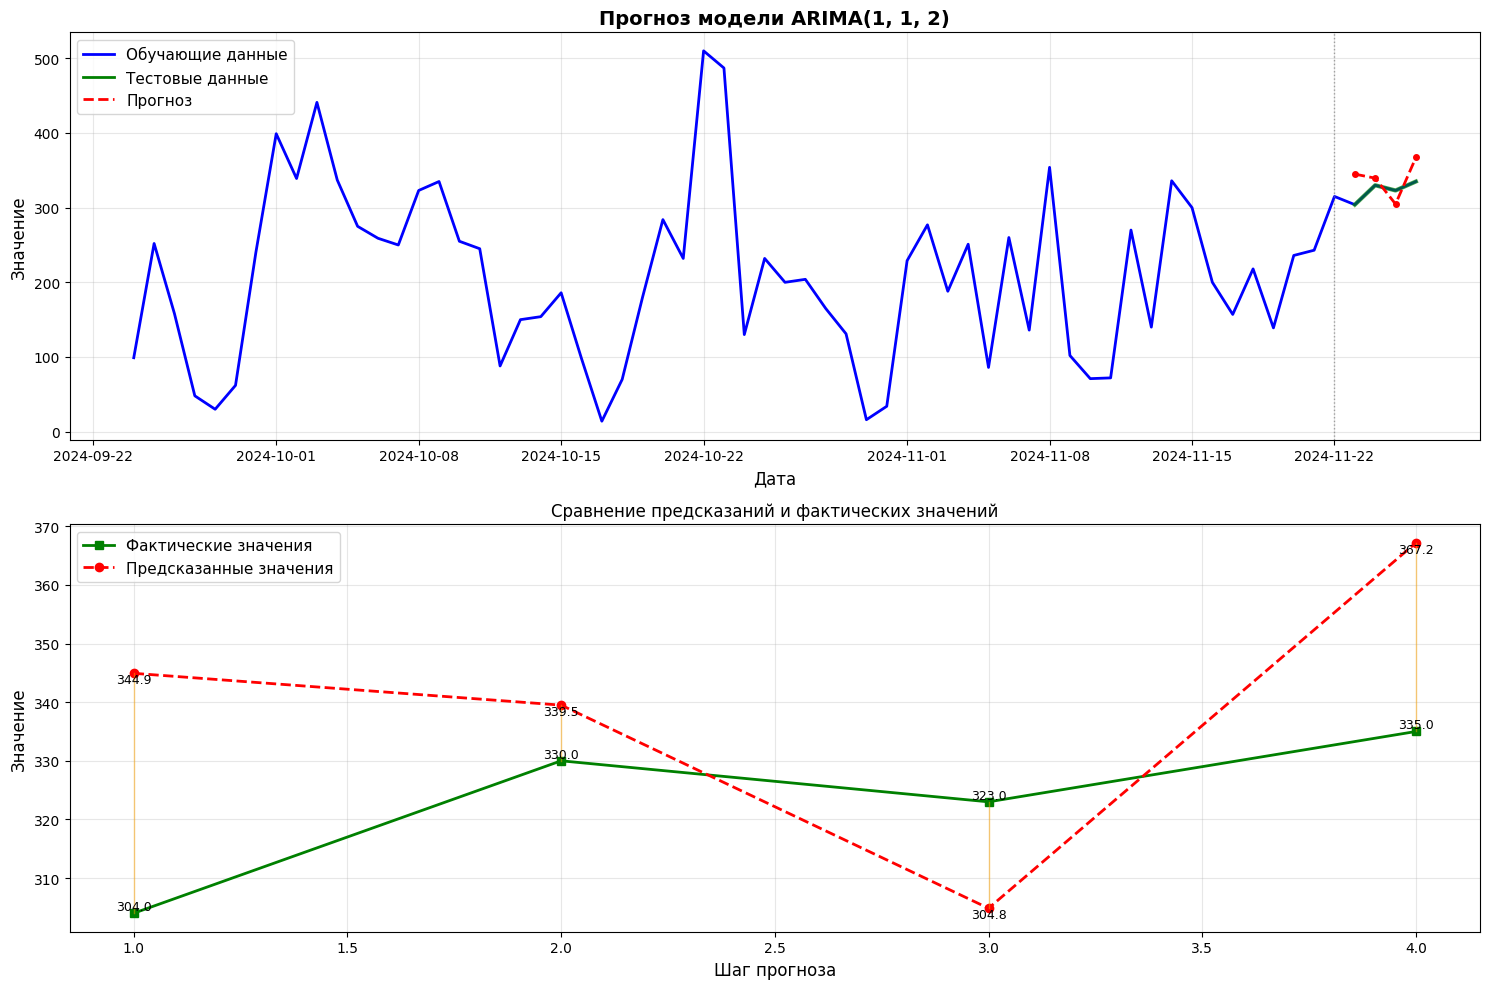

In [33]:
forecast, model, order = forecast_arima(
    train_s_ok, test_s_ok,
    auto_params=True, # ставим автоматический поиск лучшей модели по сетке параметров
    difference_order=2, # настройка ширины окна дифференцированя
    use_seasonality_removal=True, # настройка сезонности (True - удаляем, False - оставляем)
    forecast_limit=4, # Настраиваем обрезку количества предсказаний (обрезка датаврема с конца)
    show_iterative_metrics=True # Настрока отображения метрик по каждой итерации
)

# Работа с ERR

In [34]:
err.head()

,Datetime,ERR
0,24-09-24,6
1,24-09-25,307
2,24-09-26,65
3,24-09-27,3
4,24-09-28,4


In [35]:
err['Datetime'] = pd.to_datetime(err['Datetime'], format='%y-%m-%d')
err.set_index('Datetime', inplace=True)
err = err[:'2024-11-25']
err.tail()

,ERR
Datetime,
2024-11-21,468
2024-11-22,383
2024-11-23,364
2024-11-24,404
2024-11-25,372


In [36]:
train_err, test_err = train_test_split(err, start_date='2024-09-24', end_date='2024-11-25')
train_err.tail(1), test_err.head(1)

(            ERR
 Datetime       
 2024-11-21  468,
             ERR
 Datetime       
 2024-11-22  383)

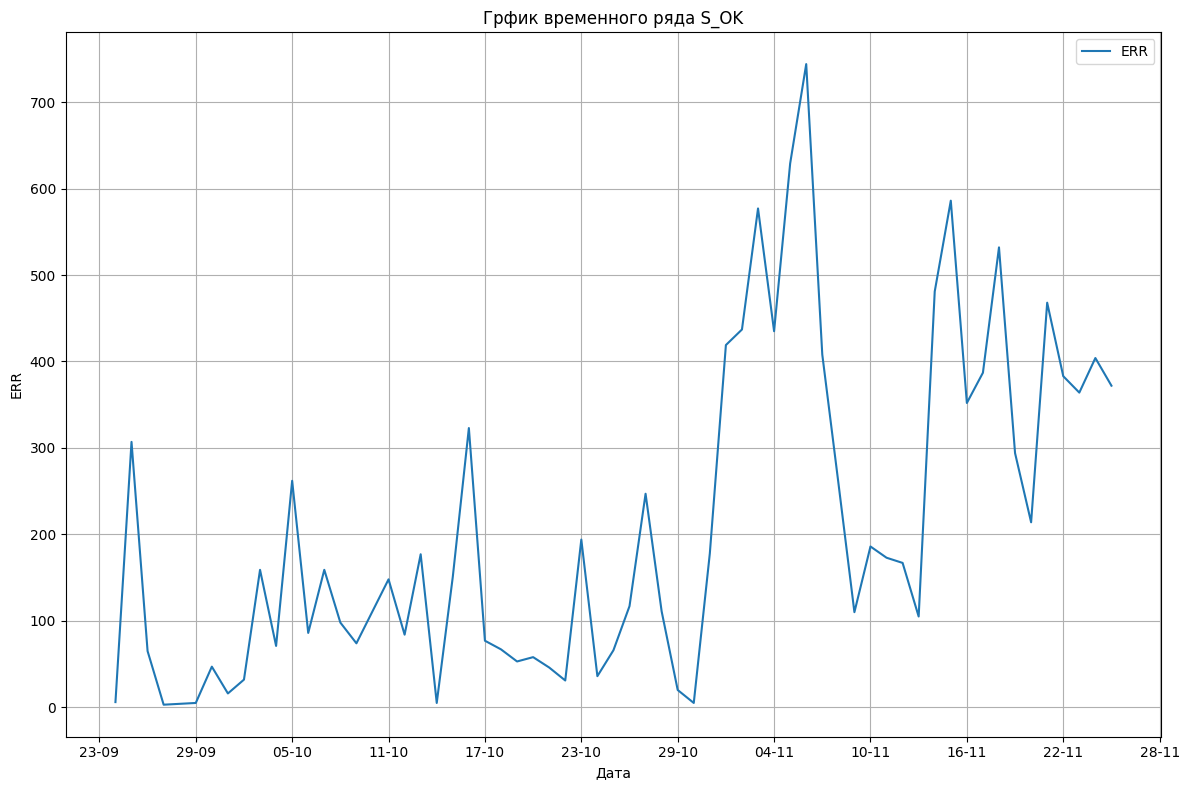

In [37]:
show_data(err, title='Грфик временного ряда S_OK', y_label=str(*err.columns))

Разложение временного ряда на основные компоненты

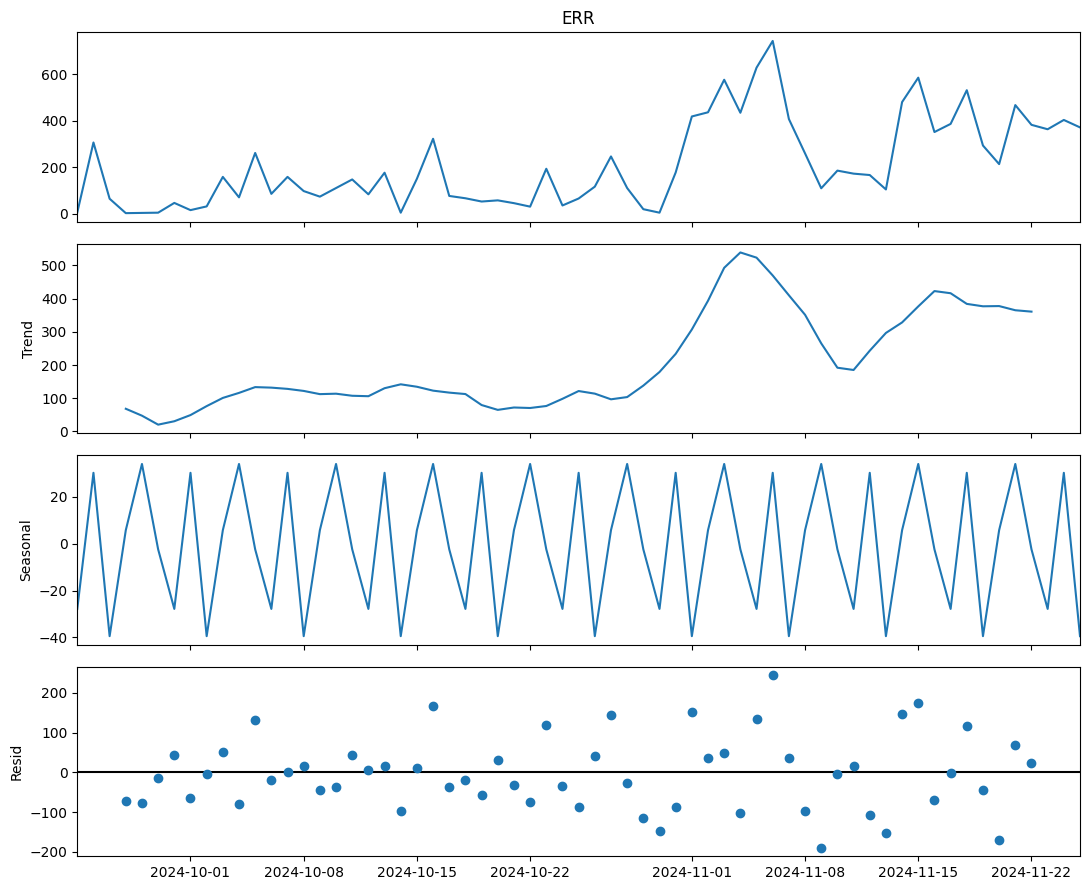

In [38]:
seasonal(err)

Сезонность недельная. Есть небольшой тренд на рост, но врядли он значительный. Есть больште занчения остатков, связанные с выбросами

In [39]:
dickey_fuller_test(err)


Результаты теста Дики-Фуллера для 'ERR':
ADF статистика: -3.2504
P-значение:      0.0172
Результат (α=0.05): СТАЦИОНАРЕН

Критические значения:
  1%%: -3.541 (ADF >= -3.541)
  5%%: -2.909 (ADF < -2.909)
  10%%: -2.592 (ADF < -2.592)



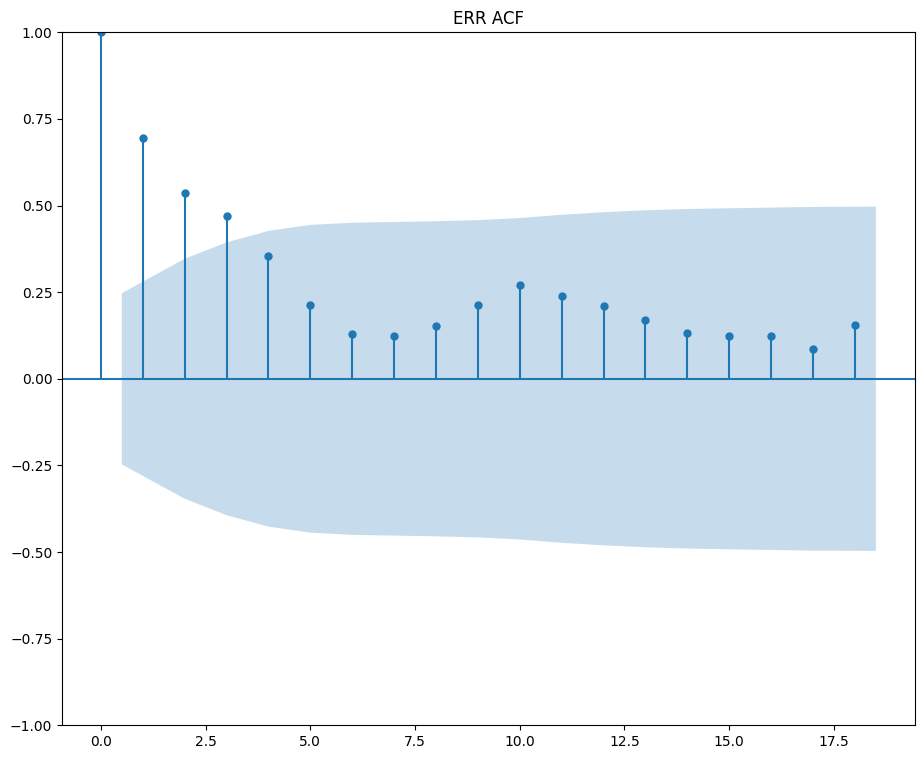

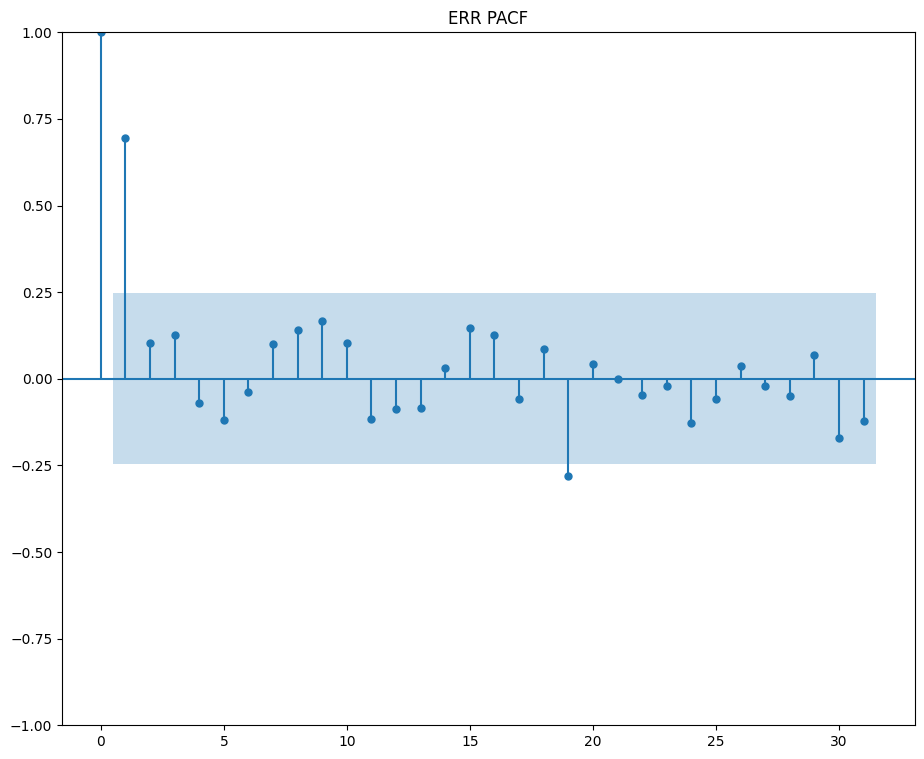

In [40]:
show_auto_correlation_grafs(err, title='ERR')

Продиференцируем графики для повышения стационарносить и устранания проблемы, того что на ACF значения только положительные

Дифференцируем только train

In [41]:
train_err_diff, original_last_values_err = difference_series(train_err)

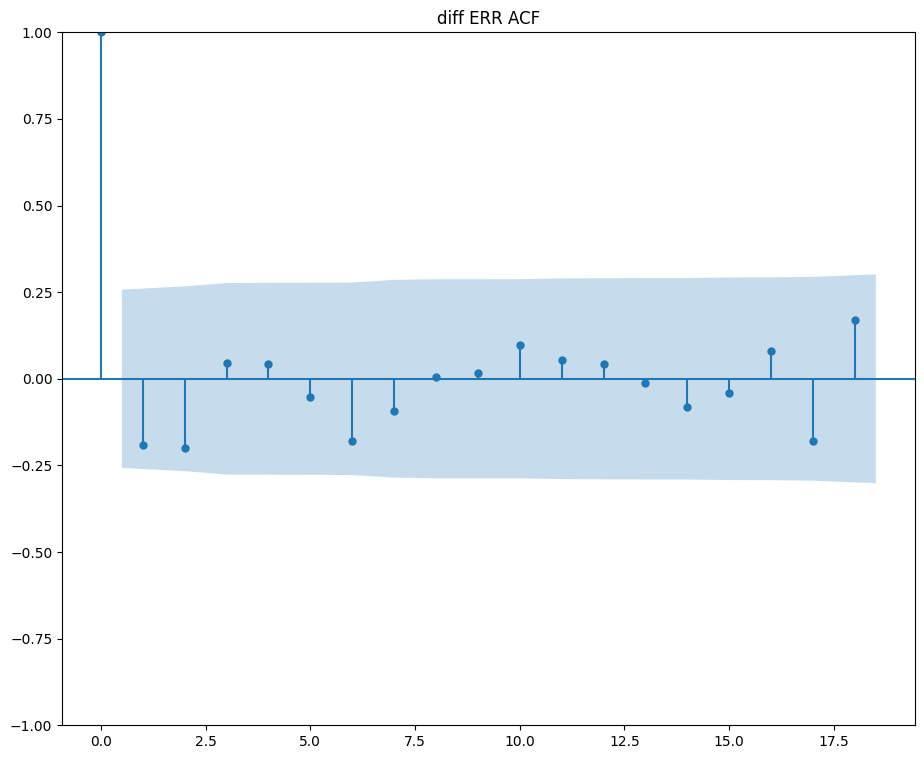

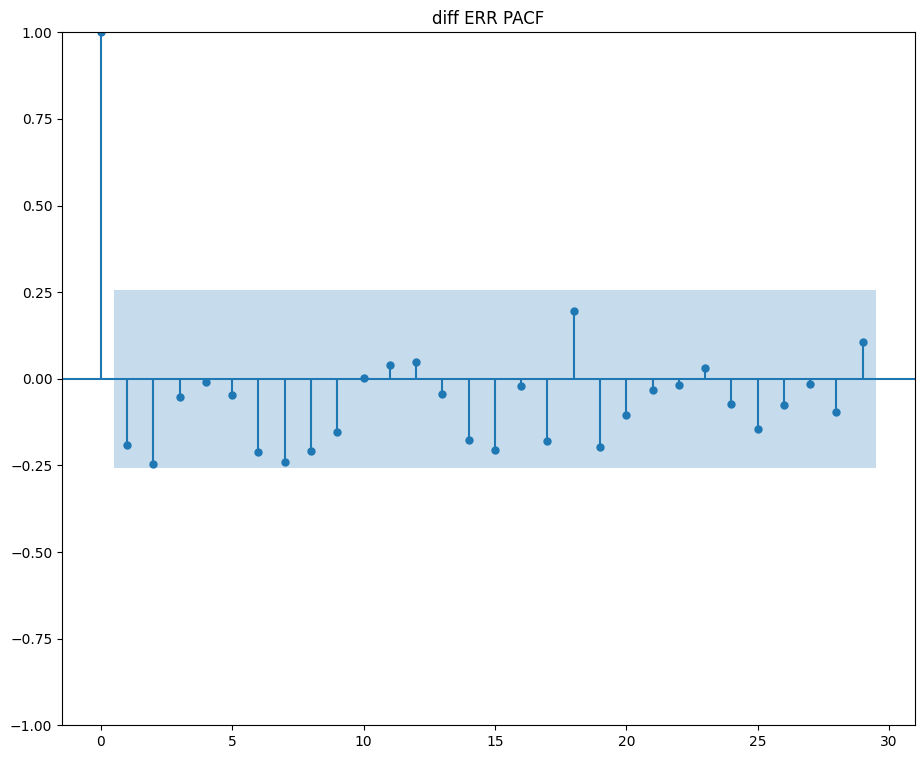

In [42]:
show_auto_correlation_grafs(train_err_diff, title='diff ERR')

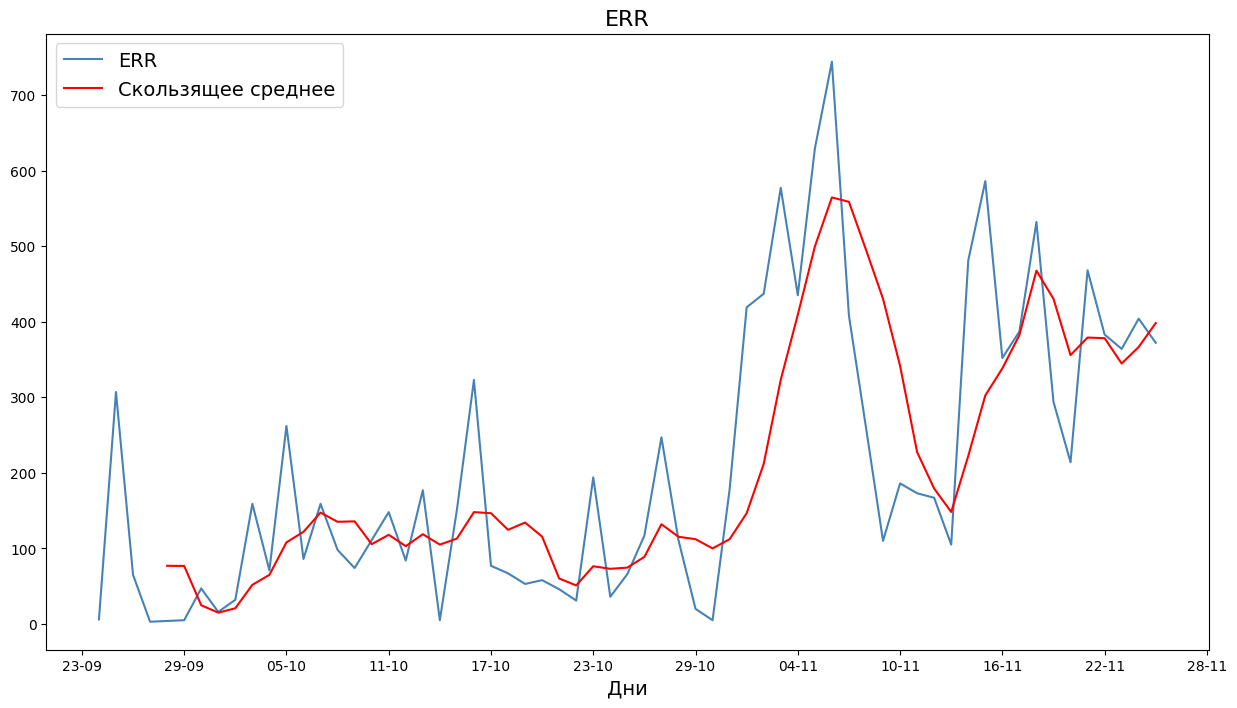

In [43]:
plot_with_rolling_window(err, window=5) # при помощи параметра window можно настроить ширину скользящего окна

Размер обучающей выборки: 59
Размер тестовых данных: 4
Прогноз на 4 шагов вперед
Удалена сезонность с периодом 7 (только на train)
ARIMA(0,0,0) - AIC: 785.94
ARIMA(0,0,1) - AIC: 760.62
ARIMA(0,0,2) - AIC: 758.14
ARIMA(1,0,0) - AIC: 749.15
ARIMA(1,0,1) - AIC: 750.72
ARIMA(1,0,2) - AIC: 751.92
ARIMA(2,0,0) - AIC: 750.90
ARIMA(2,0,1) - AIC: 752.99
ARIMA(2,0,2) - AIC: 753.46
ARIMA(0,1,0) - AIC: 740.94
ARIMA(0,1,1) - AIC: 739.15
ARIMA(0,1,2) - AIC: 737.70
ARIMA(1,1,0) - AIC: 740.82
ARIMA(1,1,1) - AIC: 736.71
ARIMA(1,1,2) - AIC: 738.67
ARIMA(2,1,0) - AIC: 738.72
ARIMA(2,1,1) - AIC: 740.72
ARIMA(2,1,2) - AIC: 740.20

Лучшая модель: ARIMA(1, 1, 1) с AIC: 736.71

SUMMARY МОДЕЛИ ARIMA(1, 1, 1)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   59
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -365.357
Date:                Fri, 19 Dec 2025   AIC                           

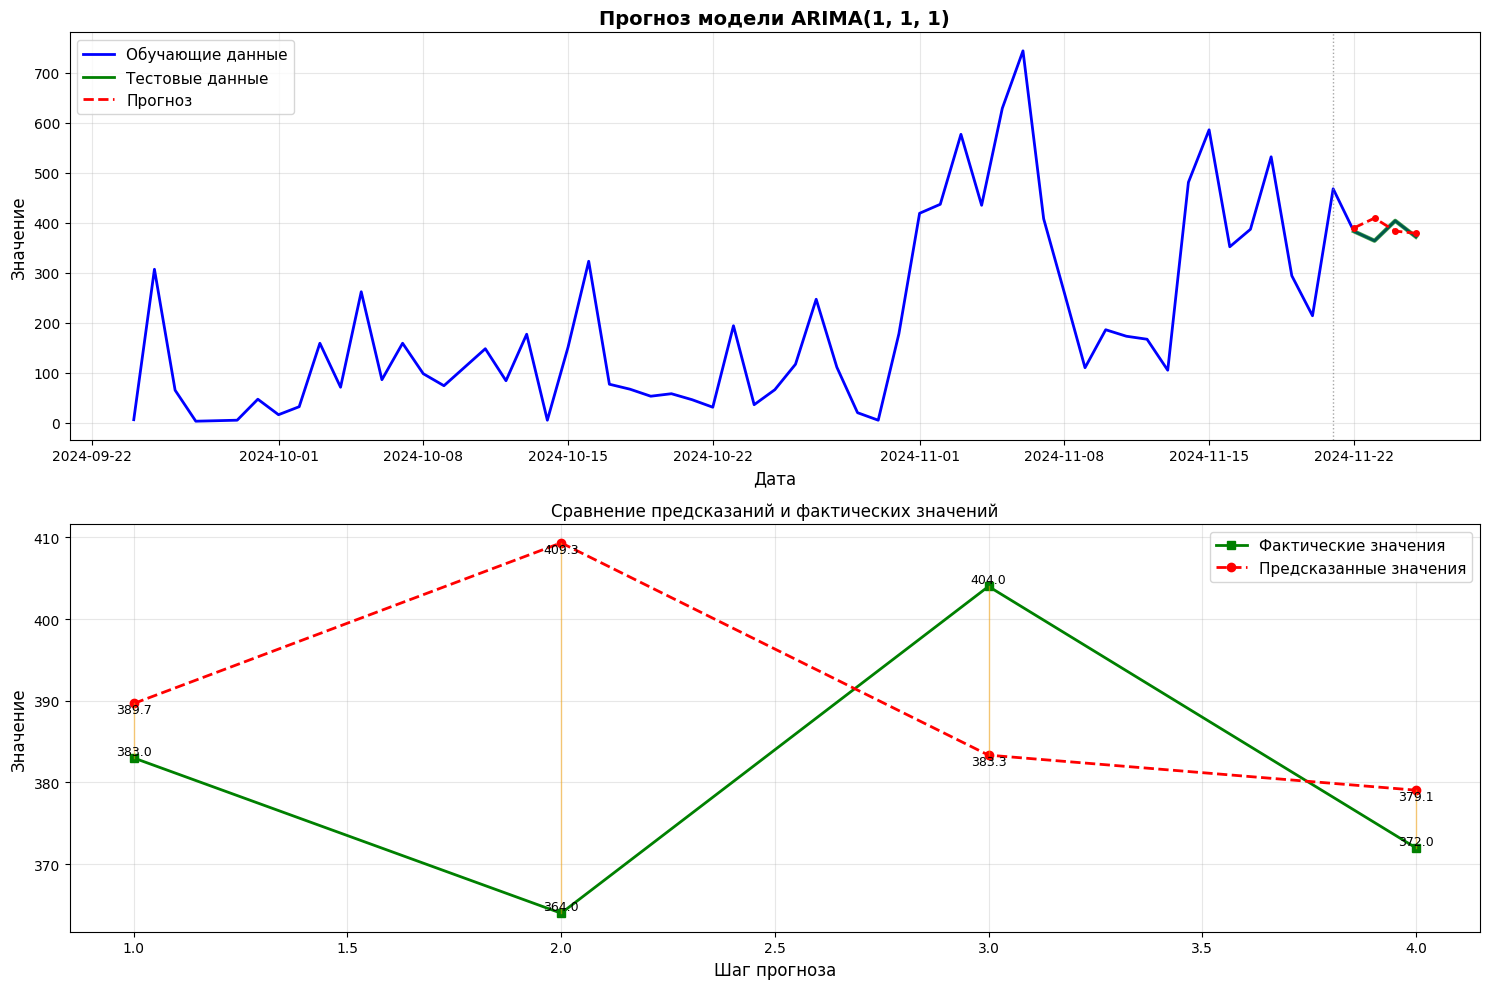

In [44]:
forecast, model, order = forecast_arima(
    train_err, test_err,
    auto_params=True, # ставим автоматический поиск лучшей модели по сетке параметров
    difference_order=0, # настройка ширины окна дифференцированя
    use_seasonality_removal=True, # настройка сезонности (True - удаляем, False - оставляем)
    forecast_limit=5, # Настраиваем обрезку количества предсказаний (обрезка датаврема с конца)
    show_iterative_metrics=True # Настрока отображения метрик по каждой итерации
)

In [45]:
err.equals(war)

False